- **This code computes the decomposed solution of a Closed-Loop DRTO problem.**
- The underlying control structure (modeled in the CLDRTO model) is an MPC, which can is solved using three different strategies: 1. unconstrained, 2. constrained using binaries, and 3. constrained using MPCC
- The problem is posed as a scenario-based stochastic programming problem
- The case study is an affine multiple parallel bioreactor system from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The uncertainty represented by the scenarios comes from the maximum specific growth rate (V_m) --> see matlab file

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [1]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, CSV, DataFrames, Distributions

# Bioreactor Model

$\dfrac{d C}{d t} = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$ \dfrac{d P}{d t} = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$

In [2]:
# Sampling time
T = 1 #[h]
# Simulation time in sampling periods
nsim = 20

# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 5.0 # for tight constraints: 1.9 | for loose constraints: 5.0
uMin = 0.0;

yspMax = 1.2 
yspMin = 0.0;

# Building affine CL-DRTO models

## Model linearization
- linearization is done using Matlab's functions ss and c2d (see BioReactorLinearization.m)
- sample time $\Delta t$ is consider as 1h
- linearization around point: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\], $C_{in,0} = 1$ \[g/L\], $C_{0} = 0.358$ \[g/L\], and $P_{0} = 0.642$ \[g/L\]

which leads to: <br>
$\bar{x}_{k+1} = A \bar{x}_k + B \bar{u}_k$ <br>
$\bar{y}_k = C \bar{u}_k$

where, <br>
$\bar{x} = \begin{bmatrix}
\bar{C}\\
\bar{P}
\end{bmatrix} =
\begin{bmatrix}
C - C_0\\
P - P_0
\end{bmatrix}$<br>
$\bar{u} = \bar{C}_{in} = C_{in} - C_{in,0}$<br>
$\bar{y} = \bar{P} = P - P_0$

In [3]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821

# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\CLDRTO Case Study 2 - Bioreactor\\BioreactorModel", DataFrame; header=false);
#print(bioModels)

CL-DRTO configuration

In [4]:
# DRTO sampling time
nDRTO = 4 # [h]
# Prediction horizon
pD = 20 + (8 - 1) # p = 8 *controller horizon
# Input control horizon 
mD = 20
# Objective function: target tracking (deviation form)
pTrack = 1 - y0 # [g/L]
# Soft upper bounds on P weight (deviation form)
pUB = 1.05 - y0 # [g/L]
# objective function weight for P penalization term 
wP = 100;

DRTO model changes with the number of scenarios and parallel reactors

In [5]:
function DRTO_matrices(nReactors,nScenarios)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenarios - number of scenarios used in the stochastic optimization
    
    # picking up indexes equally spaced between 1 and 100 (including initial and end point) 
    # based on the desired number of scenarios
    if nScenarios == 1
        indexScen = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenarios-1)) for ii in 1:nScenarios]
    end
    
    # building DRTO model
    A_drto = Array{Float64}(undef,nx,nx,nScenarios) 
    B_drto = Array{Float64}(undef,nx,nu,nScenarios) 

    for kk in 1:nScenarios

        index_temp = indexScen[kk]

        A_drto[:,:,kk] = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
        B_drto[:,:,kk] = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    end

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1], outer = [1, nReactors]);
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

In [6]:
function DRTO_matrix(nReactors,nScenario)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenario - index the of scenario used in the stochastic optimization
  
    # building DRTO model
    A_drto = kron(I(nReactors),Matrix(bioModels[2*(nScenario - 1) + 1:2*(nScenario - 1) + 2,1:2]))
    B_drto = repeat(bioModels[2*(nScenario - 1) + 1:2*(nScenario - 1) + 2,3], outer = [nReactors, 1, 1])

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1], outer = [1, nReactors]);
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

# Building MPC model

Controller configuration

In [7]:
# MPC sampling time
nMPC = 1 # [h]

# Controller configuration
# Output prediction horizon
p = 8
# Input control horizon 
m = 2
# Output weights
q = 1
# Input weights 
r = 1;

Notes:
- Using nominal model(indexScen = 50)
- For the description of how the MPC matrices (with disturbance model) are built, check script: *CLDRTO with unconstrained MPC - uncertain plant test*

In [8]:
function MPC_matrices(nReactors)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    
    # extracting the matrices from the model array computed previously
    nNom = 50 # nominal model --> index = 50
    
    A = kron(I(nReactors),Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2])) 
    B = repeat(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3], outer = [nReactors, 1])
    C = repeat([0 1], outer = [1, nReactors])
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

# Solving CL-DRTO Multiscenario Problem (monolithic)
 - Check details in script *Monolithic CLDRTO*
 - For the description of the different solution strategies, check *Different Strategies to solve constrained MPC within CLDRTO*

In [9]:
# Parameters for MPC solution
# matrix to compute the gradients of the input bound constraints
conMatrix = [I(m); -I(m)]; 

# big-M implementation
bigM_mu = 10000#1000
bigM_u = 10000#100

# weight complementarity relaxation OF term
pi_bar = 10^2; # 10^2

In [10]:
## Modeling the sub problem (scenario) -- modeling inside a function
function MS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    drto = DRTO_matrices(nReac,nScen)
    
    # Define model
    if option == 3
        model_ms = Model(Ipopt.Optimizer)
        set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    else 
        model_ms = Model(CPLEX.Optimizer)
        set_optimizer_attribute(model_ms, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(model_ms)
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, xDRTO[1:pD,1:nx,1:nScen])
    @variable(model_ms, yDRTO[1:pD,1:nScen])
    
    # MPC model variables
    @variable(model_ms, xMPC[1:pD,1:nx,1:nScen])
    @variable(model_ms, yMPC[1:pD,1:nScen])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:pD,1:nScen])
    
    # inputs computed by MPCs
    @variable(model_ms, u[1:pD,1:m,1:nScen])
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, (yspMin - y0) ≤ ysp[1:pD,1:nScen] ≤ (yspMax - y0))
    
    # slacks for P soft constraint
    @variable(model_ms, delta_p[1:pD,1:nScen] ≥ 0)
    
    if option == 2 || option == 3
        @variable(model_ms, mu_g[1:mD,1:(2*m),1:nScen] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(model_ms, Y_lb[1:mD,1:m,1:nScen], Bin, start = 0) # Binaries for big-M implementation
        @variable(model_ms, Y_ub[1:mD,1:m,1:nScen], Bin, start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ss in 1:nScen
            for ii in 1:pD
                set_start_value(yDRTO[ii,ss], solNom['y'][ii,1]) 
                set_start_value(yMPC[ii,ss], solNom['c'][ii,1])
                set_start_value(ysp[ii,ss], solNom['s'][ii,1])

                for rr in 1:nReac # when nReac increases, the number of states change!
                    for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                        set_start_value(xDRTO[ii,xx + (rr - 1)*2,ss], solNom['x'][ii,xx,1])    
                        set_start_value(xMPC[ii,xx + (rr - 1)*2,ss], solNom['m'][ii,xx,1])           
                    end # end xx
                end # number 
                
                for uu in 1:m
                    set_start_value(u[ii,uu,ss], solNom['u'][ii,uu,1])
                end # end of uu
            end # eend of ii
        end # end of ss
    end # end of if
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, CLDRTO_dyn_model_1[ss=1:nScen], xDRTO[1,:,ss] .== drto['A'][:,:,ss]*xInit + drto['B'][:,:,ss]*uInit)
    @constraint(model_ms, CLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], xDRTO[kk + 1,:,ss] .== drto['A'][:,:,ss]*xDRTO[kk,:,ss] + drto['B'][:,:,ss]*u[kk,1,ss])
    @constraint(model_ms, CLDRTO_model_out[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] == dot(drto['C'],xDRTO[kk,:,ss]))
    
    # Model Dynamic for Controller
    @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
    @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
    @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

    #  Model deviation
    @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

    # fixing setpoint changes after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,1,ss] .== u[mD,1,ss])
    
    # P soft constraints
    @constraint(model_ms, soft_P[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] - delta_p[kk,ss] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], ysp[kk,1] - ysp[kk,ss] == 0.0);
    
    ################
    # MPC solution #
    ################
    @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
    @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

    if option == 1
        # Unconstrained MPC solution  
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], mpc['H']*u[1,:,ss] + cfT_1[ss]' .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], mpc['H']*u[kk,:,ss] + cfT[kk,ss]' .== 0)
        
        # input clipping directly into DRTO problem
        @constraint(model_ms, MPC_c_upper[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, MPC_c_lower[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
        
    elseif option == 2
        # Constrained with binaries
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(model_ms, bigM_1[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu,ss] ≤ bigM_mu*Y_ub[kk,uu,ss])
        @constraint(model_ms, bigM_2[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu + m,ss] ≤ bigM_mu*Y_lb[kk,uu,ss])
        @constraint(model_ms, bigM_3[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu,ss]))
        @constraint(model_ms, bigM_4[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≥ -bigM_u*(1 - Y_lb[kk,uu,ss]))
        
        @constraint(model_ms, compSlack[kk=1:mD,uu=1:m,ss=1:nScen], Y_ub[kk,uu,ss] + Y_lb[kk,uu,ss] ≤ 1)
    
    elseif option == 3
        # Constrained with MPCC
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, MPC_c_upper[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, MPC_c_lower[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
        
        # Expressions for OF
        @expression(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0))
        @expression(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss])
        
    end
        
    #############################
    # Set up objective function #
    #############################
    if option == 1 || option == 2
        @objective(model_ms, Min, 
            pScen*sum((yDRTO[kk,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
        )
    else
        @objective(model_ms, Min, pScen*sum((yDRTO[kk,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
                                - pScen*pi_bar*sum(
                                                sum(mu_g[kk,jj,ss]*g_u_u[kk,jj,ss] for jj = 1:m) +
                                                sum(mu_g[kk,jj + m,ss]*g_u_l[kk,jj,ss] for jj = 1:m)
                                                for kk = 1:mD, ss in 1:nScen)
        )
    end
    # @show model_ms

    #################
    # Solve Problem #
    #################
    #set_optimizer_attribute(model_ms, "CPX_PARAM_BARALG", 1)
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)

        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xDRTOArray,
                        'c' => yDRTOArray)
        
        if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputFun,Dict('μ'=> muArray))
        end
        
        return outputFun
    else
        # Handle other cases.
        outputFun = Dict('f' => 0,
                         't' => NaN,
                         'ϕ' => NaN)
                        
        
        return outputFun
    end
end;

# Decomposition of CLDRTO Problem

<div>
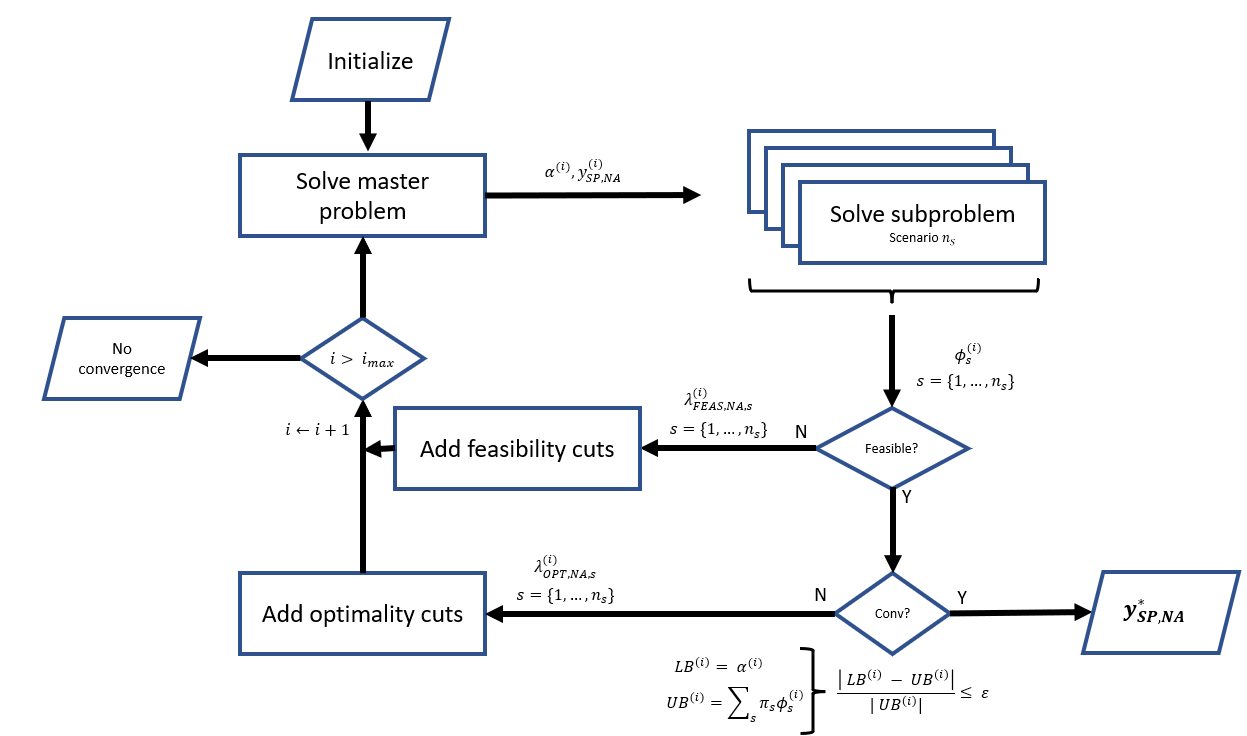
</div>

## Modeling Subproblem

In [11]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(xInit,uInit,ysp_fixed,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # ysp_fixed - setpoints fixed by the Master Problem --> nonanticipativity constraints
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC 
        # for now, code only works for option = 3

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    drto = DRTO_matrix(nReac,nScen)
    
    # Define subproblem model  #== 3
    if option == 3  
        sub = Model(Ipopt.Optimizer)
        set_optimizer_attribute(sub, "max_cpu_time", 300.0) # 5 min
    else 
        sub = Model(CPLEX.Optimizer)
        set_optimizer_attribute(sub, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(sub) # avoid printing
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(sub, xDRTO[1:pD, 1:nx])
    @variable(sub, yDRTO[1:pD])
    
    # MPC model variables
    @variable(sub, xMPC[1:pD, 1:nx])
    @variable(sub, yMPC[1:pD])

    # MPC <-> DRTO model deviation
    @variable(sub, de[1:pD])
    
    # inputs computed by MPCs
    @variable(sub, u[1:pD,1:m])

    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(sub, (yspMin - y0) ≤ ysp[1:pD] ≤ (yspMax - y0))
        
    # slacks for controlling setpoint into a zone
    @variable(sub, delta_p[1:pD] ≥ 0)
    
    if option == 2 || option == 3
        @variable(sub, mu_g[1:mD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(sub, Y_lb[1:mD,1:m], start = 0) # Relaxing binaries for big-M implementation
        @variable(sub, Y_ub[1:mD,1:m], start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:pD
            set_start_value(yDRTO[ii], solNom['y'][ii,1]) 
            set_start_value(yMPC[ii], solNom['c'][ii,1])
            #set_start_value(ysp[ii], solNom['s'][ii,1])

            for rr in 1:nReac # when nReac increases, the number of states change!
                for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                    set_start_value(xDRTO[ii,xx + (rr - 1)*2], solNom['x'][ii,xx,1])    
                    set_start_value(xMPC[ii,xx + (rr - 1)*2], solNom['m'][ii,xx,1])           
                end # end xx
            end # number 
                
            for uu in 1:m
                set_start_value(u[ii,uu], solNom['u'][ii,uu,1])
            end # end of uu
        end # eend of ii
    end # end of if

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(sub, CLDRTO_dyn_model_1, xDRTO[1,:] .== drto['A']*xInit + drto['B']*uInit)
    @constraint(sub, CLDRTO_dyn_model[kk=1:(pD - 1)], xDRTO[kk + 1,:] .== drto['A']*xDRTO[kk,:] + drto['B']*u[kk,1])
    @constraint(sub, CLDRTO_model_out[kk=1:pD], yDRTO[kk] == dot(drto['C'],xDRTO[kk,:]))

    # MPC model (linear)
    @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
    @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
    @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))
    
    #  MPC model deviation (disturance)
    @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

    # fixing input after mD
    @constraint(sub, control_horizon[kk=(mD+1):pD], u[kk,1] == u[mD,1]);
    
    # P soft constraints
    @constraint(sub, soft_P[kk=1:pD], yDRTO[kk] - delta_p[kk] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(sub, nonAnt[kk=1:nDRTO], ysp[kk] - ysp_fixed[kk] == 0.0);
    
    ################
    # MPC solution #
    ################
    @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
    @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

    if option == 1
        # Unconstrained MPC solution  
        @constraint(sub, MPC_sol_1, mpc['H']*u[1,:] + cfT_1' .== 0)
        @constraint(sub, MPC_sol[kk=2:mD],mpc['H']*u[kk,:] + cfT[kk]' .== 0)
        
        # input clipping directly into DRTO problem
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
    
    elseif option == 2
        # Constrained with binaries
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(sub, bigM_1[kk=1:mD,uu=1:m], mu_g[kk,uu] ≤ bigM_mu*Y_ub[kk,uu])
        @constraint(sub, bigM_2[kk=1:mD,uu=1:m], mu_g[kk,uu + m] ≤ bigM_mu*Y_lb[kk,uu])
        @constraint(sub, bigM_3[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu]))
        @constraint(sub, bigM_4[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≥ -bigM_u*(1 - Y_lb[kk,uu]))
        
        @constraint(sub, compSlack[kk=1:mD,uu=1:m], Y_ub[kk,uu] + Y_lb[kk,uu] ≤ 1)
    
    elseif option == 3
        # Constrained with MPCC
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility       
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
        
        # expression to be used in OF        
        @expression(sub, g_u_u[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0))
        @expression(sub, g_u_l[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu])
        
    end
  
    #############################
    # Set up objective function #
    #############################
     if option == 1 || option == 2
        @objective(sub, Min, 
            pScen*sum((yDRTO[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:pD)
        )
    else
        @objective(sub, Min, 
            pScen*sum((yDRTO[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:pD)
                    - pScen*pi_bar*sum(
                                    sum(mu_g[kk,jj]*g_u_u[kk,jj] for jj = 1:m) +
                                    sum(mu_g[kk,jj + m]*g_u_l[kk,jj] for jj = 1:m)
                                for kk = 1:mD)
        )
    end
    
    # @show sub
    #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)
    
    optimize!(sub)
    
    # solution time
    timeSol = solve_time(sub)
    
    status = termination_status(sub)
    #display(status)
    
    # checking if there is a solution to the problem
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # we add an optimality cut
        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(sub)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ = dual.(nonAnt)

        outputDict = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
        if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    else
        #i.e. no feasible solution --> Add feasibility cut
        #display("Feasibility cut: scenario $(scen)")        

        # ! soft bounds on u
        for kk in 1:mD
            for uu in 1:m
                delete(sub, MPC_c_upper[kk,uu])
                delete(sub, MPC_c_lower[kk,uu])
            end
        end
        # ! soft bounds on ysp
        delete_lower_bound.(ysp[1:pD])
        delete_upper_bound.(ysp[1:pD])
        
        if option != 1
            # ! soft bounds on mu
            delete_lower_bound.(mu_g[1:mD,1:m])
        end
        
        ####################
        # Set up variables #
        #################### 
        # slacks
        @variable(sub, delta_u_u[1:mD,1:m] ≥ 0.0)
        @variable(sub, delta_u_l[1:mD,1:m] ≥ 0.0)
        
        @variable(sub, delta_ysp_u[1:pD] ≥ 0.0)
        @variable(sub, delta_ysp_l[1:pD] ≥ 0.0)
        
        if option == 2 || option == 3
            @variable(sub, delta_mu[1:mD,1:m] ≥ 0.0)
        end
        
        ###########################
        # Always-feasible problem #
        ###########################        
        # adding a constraint to guarantee feasibility
        @constraint(sub, soft_u_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ delta_u_u[kk,uu])
        @constraint(sub, soft_u_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ delta_u_l[kk,uu])
        
        @constraint(sub, soft_ysp_upper[kk=1:pD], ysp[kk] - (yspMax - y0) ≤ delta_ysp_u[kk])
        @constraint(sub, soft_ysp_lower[kk=1:pD], (yspMin - y0) - ysp[kk] ≤ delta_ysp_l[kk])

        # adding a constraint to guarantee that mu is always feasible        
        if option == 2 || option == 3
            @constraint(sub, soft_MPC_mu_upper[kk=1:mD,uu=1:m], -mu_g[kk,uu] ≤ delta_mu[kk,uu])
        end
        
       #############################
        # Set up objective function #
        #############################
        # Modifying the objective --> call @objective with the new objective function.
        # minimizing constraint violation - l1 penalty!
        if option == 2 || option == 3
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD)
                    + sum(sum(delta_mu[kk,uu] + delta_u_u[kk,uu] + delta_u_l[kk,uu] for uu in 1:m) for kk in 1:mD))
        else
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD)
                    + sum(sum(delta_u_u[kk,uu] + delta_u_l[kk,uu] for uu in 1:m) for kk in 1:mD))
        end
        
        #@show sub
        #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)

        # re-optimizing (now using the always feasible problem)
        optimize!(sub)
        
        # solution time (adding time to solve the always feasible subproblem)
        timeSol = timeSol + solve_time(sub)
        
        # checking status of the solution
        status_sub = termination_status(sub)
        
        # flag for calling feasibility cuts (not optimality cuts)
        flag = 0
        
        #calling values of the solved problem
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
        
        #delta_muArray = value.(delta_mu)
        delta_ulArray = value.(delta_u_l)
        delta_uuArray = value.(delta_u_u)
    
        # objective function of the feasibility problem
        o = objective_value(sub)
        
        # lagrange multipliers associated with the nonantecipativity constraints and binaries from master problem
        λ = dual.(nonAnt)
        
        outputDict = Dict('ϕ' => o,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status_sub,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
         if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    end
end;

Modeling Bender's Decomposition

In [12]:
# max number of iteration
benIterMax = 50

# optimality gap (relative) tolerance
optGap = 0.001; # UNC/BIN: 0.001 | MPCC: 0.5

In [13]:
## Modeling Benders Decompostion
function BENS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    
    
    # flag for checking if last cut was opt. (1) or feas. (0)
    flagO = 1
    
    # timing solution via Benders
    timeSolBen = 0 
    # timing solution via parallel Benders
    timeSolParBen = 0 
    
    # Define master problem model
    master = Model(CPLEX.Optimizer)
    set_silent(master)
    
    #lower bound on scenario objective function approximation 
    alpha_down = 0.0;
    
    ####################
    # Set up variables #
    ####################
    @variable(master,  (yspMin - y0) <= ysp[1:nDRTO] <=  (yspMax - y0))     
    @variable(master, α ≥ alpha_down)
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:nDRTO
            set_start_value(ysp[ii], solNom['s'][ii,1])
        end 
    end 
 
    ################################################
    # Solving problem with benders' decomposition  #
    ################################################
    for ii in 1:benIterMax
           
        #############################
        # Set up objective function #
        #############################
        if flagO == 1 
            # last cut was an optimality cut
            # standard OF
            @objective(master, Min, α)
        else
            # last cut was a feasibility cut
            # "nudge" next solution towards nominal solution 
            @objective(master, Min, α + 0*sum((ysp[kk] - solNom['s'][kk,1])^2 for kk in 1:nDRTO))
        end
        
            # solve master problem (with Benders' cut)
            optimize!(master)

            # solution time
            timeSolMaster = solve_time(master)
            # Master problem solution: lower bound of the original problem
            lb = objective_value(master)
            #display(lb)

            # extracting solution for the non-anticipativity constraints
            ysp_nonⁱ = value.(ysp)
            #display(ysp_nonⁱ)

        timeSolBen = timeSolBen + timeSolMaster
        timeSolParBen = timeSolParBen + timeSolMaster # master cannot be paralellized 

        #######################
        # Solving subproblems #
        #######################
        # objective function
        o_temp = Vector{Float64}(undef,nScen)
        # flag optimality / feasibility
        flag_temp = Vector{Float64}(undef,nScen)
        # solution time
        solTime_temp = Vector{Float64}(undef,nScen)
        # multipliers
        lambdaN_temp = Matrix{Float64}(undef,nDRTO,nScen) 
        
        for ss in 1:nScen
            dicTemp = subp(xInit,uInit,ysp_nonⁱ,nReac,ss,pScen,solNom,option)
           
            # saving files
            # objective function
            o_temp[ss] = dicTemp['ϕ']
            # solution time
            solTime_temp[ss] = dicTemp['t']
            # optimality / feasibility flag
            flag_temp[ss] = dicTemp['f']
            # multiplier
            for kk in 1:nDRTO
                lambdaN_temp[kk,ss] = dicTemp['λ'][kk]
            end
            
        end
        
        ##########################################################
        # If all subproblems were feasible, check optimality gap #
        ##########################################################
        if sum(flag_temp) == nScen 
            # Subproblem solution: upper bound of the original problem
            ub = sum(o_temp)

            # solve subproblems to find the upper bound of the original problem solution 
            timeSolBen = timeSolBen + sum(solTime_temp)

            # assuming that subproblem solution is parallelized
            timeSolParBen = timeSolParBen + maximum(solTime_temp)   
            
            # compute optimality gap
            gap = abs(ub - lb)/abs(ub)
            #display(gap)

            # check if optimality gap is small enough
            # also, make sure last cut was an optimality cut due to change in OF 
            if gap < optGap && flagO == 1
                global yspSol_dec = ysp_nonⁱ
                global objFun_dec = ub
                global optGap_dec = gap
                global iter_dec = ii
                global time_dec = timeSolBen
                global time_max_dec = timeSolParBen
                break
            else # gap ≥ optGap 
                ##############################
                # --> adding optimality cuts #
                ##############################
                display(">>>>>> iteration $(ii):O")
                benderscutO = @constraint(master, α ≥ ub + 
                    sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
                #@info "we are adding this bender optimality cut $(benderscutO)"
                
                # optimality cut was add
                flagO = 1
            
            end # if gap
        else # sum(flag_temp) != nScen
            ###############################
            # --> adding feasibility cuts #
            ###############################
            display(">>>>>> iteration $(ii):F")

            benderscutF = @constraint(master, 0 ≥
                sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
            #@info "we are adding this bender feasibility cut $(benderscutF)"
            
            # feasibility cut was add
            flagO = 0
            
        end # if nScen
        
        # checking if number of iterations reached max 
        if ii < benIterMax
            global yspSol_dec = [NaN for kk=1:nDRTO]
            global objFun_dec = NaN
            global optGap_dec = NaN
            global iter_dec = benIterMax
            global time_dec = timeSolBen
            global time_max_dec = timeSolParBen
        end # if < benIterMax
    end # if for benders iterations

    # recomputing values
    uArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['u']' for ss in 1:nScen]
    yArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['y']' for ss in 1:nScen] 
    yspArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['s']' for ss in 1:nScen]
    
    #calling values of the solved problem
    return Dict('ϕ' => objFun_dec, 
                'd' => yspSol_dec, 
                't' => time_dec,
                'm' => time_max_dec, 
                'i' => iter_dec,
                'g'=> optGap_dec,
                'u' => uArray, 
                'y' => yArray, 
                's' => yspArray)
     
end;

# Checking the performance of the methods in terms of time vs. nScen

In [14]:
# testing the number of scenarios
nScenMax = 30

#preparing plot 
# --> monolithic vs. decomposed 
# solution time
solTimeTraj_s = Matrix{Float64}(undef,2,nScenMax) 
# computed objective function
solObjTraj_s = Matrix{Float64}(undef,2,nScenMax) 
# --> only decomposed
# max solution time over all scenarios 
solTimeMaxTraj_s = Vector{Float64}(undef,nScenMax) 
# number of iterations
iterTraj_s = Vector{Float64}(undef,nScenMax) 
# optimality gap
optGapTraj_s = Vector{Float64}(undef,nScenMax) 

# number of reactors in parallel
nReactors = 1
# Number of states
nx = 2*nReactors

# Initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReactors,1])
uInit_0 = 1.0 - u0;

#option = 1 --> Unconstrained MPC
#option = 2 --> Constrained MPC with binaries
#option = 3 --> Constrained MPC with MPCC
opti = 1
    
# Computing nominal solution #
#number of scenarios 
scenNom = 1
#equiprobable scenarios
pNom = 1.0
#number of reactors 
reacNom = 1
# number of states of the nominal solution
nx = 2*reacNom

solNominal = MS_CLDRTO(x0,u0,reacNom,scenNom,pNom,0,opti); 

for ss = 1:nScenMax
    display("evaluating $(ss) scenarios| option $(opti)")

    #number os scenarios
    nScen = ss
    #equiprobable scenarios
    pScen = 1.0/nScen
       
    # solving monolithical problem 
    sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)

    # solving decomposed problem
    sol_d_Dict = BENS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)

    # for plotting
    display("time M $(sol_m_Dict['t']) | time D $(sol_d_Dict['t'])")
    solTimeTraj_s[1,ss] = sol_m_Dict['t']
    solTimeTraj_s[2,ss] = sol_d_Dict['t']
    solObjTraj_s[1,ss] = sol_m_Dict['ϕ']
    solObjTraj_s[2,ss] = sol_d_Dict['ϕ']
    
    solTimeMaxTraj_s[ss] = sol_d_Dict['m']
    iterTraj_s[ss] = sol_d_Dict['i'] 
    optGapTraj_s[ss] = sol_d_Dict['g']
end


"evaluating 1 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.007999897003173828 | time D 0.046000003814697266"

"evaluating 2 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.012999773025512695 | time D 0.0840001106262207"

"evaluating 3 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.012999773025512695 | time D 0.14099979400634766"

"evaluating 4 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.01399993896484375 | time D 0.16300010681152344"

"evaluating 5 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.015000104904174805 | time D 0.1979999542236328"

"evaluating 6 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.017999887466430664 | time D 0.23800015449523926"

"evaluating 7 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.019999980926513672 | time D 0.3079993724822998"

"evaluating 8 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.02200007438659668 | time D 0.34999990463256836"

"evaluating 9 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.026999950408935547 | time D 0.3939988613128662"

"evaluating 10 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.026999950408935547 | time D 0.4089999198913574"

"evaluating 11 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.029999971389770508 | time D 0.4909994602203369"

"evaluating 12 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.0279998779296875 | time D 0.48599982261657715"

"evaluating 13 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.03399991989135742 | time D 0.5400011539459229"

"evaluating 14 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.03500008583068848 | time D 0.5789992809295654"

"evaluating 15 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.03800010681152344 | time D 0.6310014724731445"

"evaluating 16 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.03900003433227539 | time D 0.6720006465911865"

"evaluating 17 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.0409998893737793 | time D 0.7029983997344971"

"evaluating 18 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.04399991035461426 | time D 0.7419991493225098"

"evaluating 19 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"time M 0.0409998893737793 | time D 0.7830016613006592"

"evaluating 20 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.042999982833862305 | time D 0.6900012493133545"

"evaluating 21 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.04699993133544922 | time D 0.7329995632171631"

"evaluating 22 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.08700013160705566 | time D 0.8950004577636719"

"evaluating 23 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.057000160217285156 | time D 0.8360004425048828"

"evaluating 24 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.053999900817871094 | time D 0.8710007667541504"

"evaluating 25 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.05299997329711914 | time D 0.9479999542236328"

"evaluating 26 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.05900001525878906 | time D 0.9709992408752441"

"evaluating 27 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.06099987030029297 | time D 1.2330021858215332"

"evaluating 28 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.056999921798706055 | time D 1.129000186920166"

"evaluating 29 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.0709998607635498 | time D 1.123997449874878"

"evaluating 30 scenarios| option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

"time M 0.05800008773803711 | time D 1.0649993419647217"

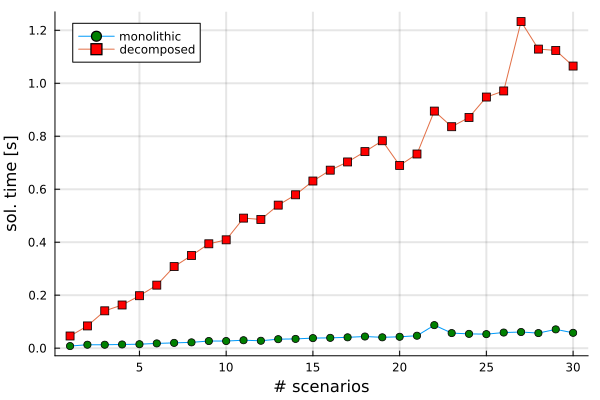

In [15]:
# solution time
p1 = plot(1:nScenMax,solTimeTraj_s[1,:],xlabel="# scenarios", ylabel="sol. time [s]",marker=:circle, markercolor = :green,label="monolithic")
p1 = plot!(1:nScenMax,solTimeTraj_s[2,:],marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p1)

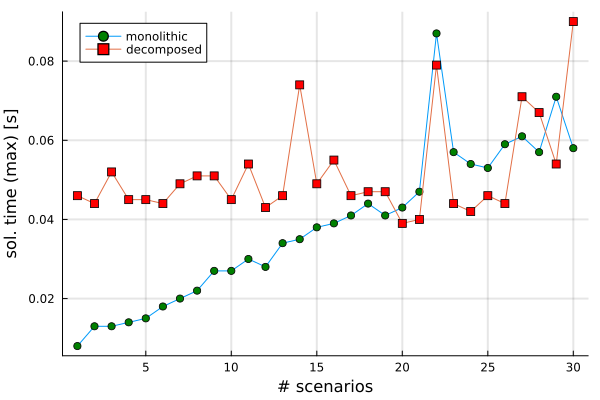

In [16]:
# solution time (parallel)
p2 = plot(1:nScenMax,solTimeTraj_s[1,:],xlabel="# scenarios", ylabel="sol. time (max) [s]",marker=:circle, markercolor = :green,label="monolithic")
p2 = plot!(1:nScenMax,solTimeMaxTraj_s,marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p2)

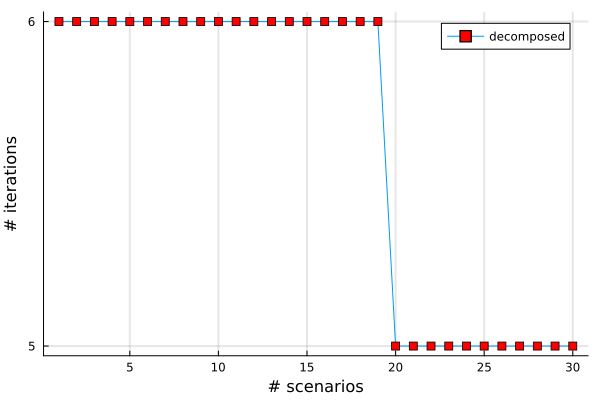

In [17]:
# number of iterations
function int_ticks(x; step=1) 
    imin = floor(Int, minimum(x))
    imax = ceil(Int, maximum(x))
    return range(imin, imax, step=step)
end

p3 = plot(1:nScenMax,iterTraj_s,xlabel="# scenarios", ylabel="# iterations",marker=:square, markercolor = :red,label="decomposed",yticks=int_ticks(iterTraj_s; step=1),gridlinewidth=2)
display(p3)

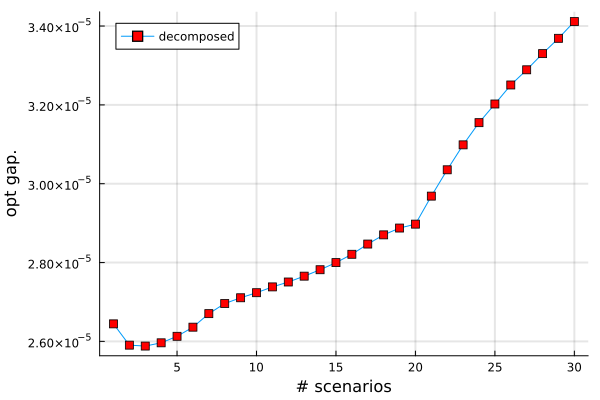

In [18]:
# number of iterations
p4 = plot(1:nScenMax,optGapTraj_s,xlabel="# scenarios", ylabel="opt gap.",marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p4)

# Checking the performance of the methods in terms of time vs. nReac

In [19]:
# testing the number of reactors in series (chosen arbitrarily as the same number of scenarios)
nReactMax = 30

#preparing plot 
# --> monolithic vs. decomposed 
# solution time
solTimeTraj_r = Matrix{Float64}(undef,2,nScenMax) 
# computed objective function
solObjTraj_r = Matrix{Float64}(undef,2,nScenMax) 
# --> only decomposed
# number of iterations
iterTraj_r = Vector{Float64}(undef,nScenMax) 
# optimality gap
optGapTraj_r = Vector{Float64}(undef,nScenMax) 

# number of reactors in parallel
nScenarios = 3
#equiprobable scenarios
pScenarios = 1.0/nScenarios

for rr = 1:nReactMax
    display("evaluating $(rr) reactors in parallel | option $(opti)")
        
    #number os reactors
    nReac = rr
    # Number of states
    nx = 2*nReac
        
    # Possible initial conditions (deviation form)
    xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReac,1])
    uInit_0 = 1.0 - u0
       
    # solving monolithical problem 
    sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReac,nScenarios,pScenarios,solNominal,opti)

    # solving decomposed problem    
    sol_d_Dict = BENS_CLDRTO(xInit_0,uInit_0,nReac,nScenarios,pScenarios,solNominal,opti)
        
    # for plotting
    solTimeTraj_r[1,rr] = sol_m_Dict['t']
    solTimeTraj_r[2,rr] = sol_d_Dict['t']
    
    solObjTraj_r[1,rr] = sol_m_Dict['ϕ']
    solObjTraj_r[2,rr] = sol_d_Dict['ϕ']

    iterTraj_r[rr] = sol_d_Dict['i'] 
    optGapTraj_r[rr] = sol_d_Dict['g']

end


"evaluating 1 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"evaluating 2 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 3 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"evaluating 4 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

"evaluating 5 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

"evaluating 6 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

"evaluating 7 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

"evaluating 8 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 9 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 10 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 11 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 12 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 13 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 14 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 15 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 16 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

"evaluating 17 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 18 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 19 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 20 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 21 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 22 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 23 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 24 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 25 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 26 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 27 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 28 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 29 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

"evaluating 30 reactors in parallel | option 1"

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

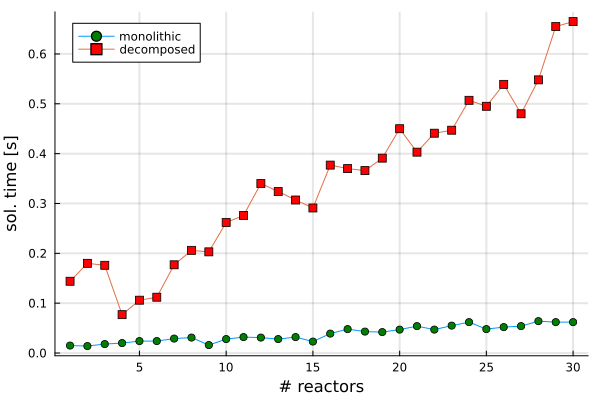

In [20]:
# solution time
p5 = plot(1:nReactMax,solTimeTraj_r[1,:],xlabel="# reactors", ylabel="sol. time [s]",marker=:circle, markercolor = :green,label="monolithic")
p5 = plot!(1:nReactMax,solTimeTraj_r[2,:],marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p5)

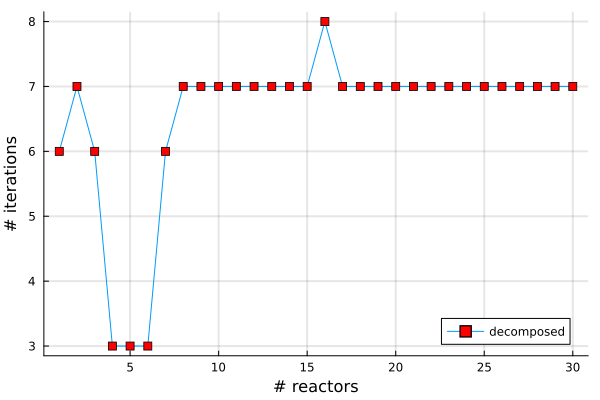

In [21]:
# number of iterations
p6 = plot(1:nReactMax,iterTraj_r,xlabel="# reactors", ylabel="# iterations",marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p6)

In [22]:
# number of iterations
p8 = plot(1:nReactMax,optGapTraj_r,yscale=:log10,xlabel="# scenarios", ylabel="opt gap.",marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p8)

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\MACC-Jose\.julia\packages\PlotUtils\bZEEj\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\MACC-Jose\.julia\packages\PlotUtils\bZEEj\src\ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 4 for log10 based yscale
└ @ Plots C:\Users\MACC-Jose\.julia\packages\Plots\QZRtR\src\utils.jl:106


# Checking if trajectories match for more scenarios and reactors
- arbitrarily chosen number of scenarios and reactors

In [23]:
nSCheck = 3 # number of scenarios
nRCheck = 5 # number of reactors in parallel
optiCheck = opti

# Extracting solution for plotting --> monolithic vs. decomposed 
yTraj = Array{Float64}(undef,2,pD,nSCheck)
uTraj = Array{Float64}(undef,2,pD,nSCheck) 
yspTraj = Array{Float64}(undef,2,pD,nSCheck) 

#equiprobable scenarios
pScheck = 1.0/nSCheck;

# Number of states
nx = 2*nRCheck;

# Initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nRCheck,1]);
uInit_0 = 1.0 - u0;

sol_mon = MS_CLDRTO(xInit_0,uInit_0,nRCheck,nSCheck,pScheck,solNominal,optiCheck)
sol_dec = BENS_CLDRTO(xInit_0,uInit_0,nRCheck,nSCheck,pScheck,solNominal,optiCheck)

for ii in 1:pD
    for ss in 1:nSCheck
    # transforming from deviation form
    yTraj[1,ii,ss] = sol_mon['y'][ii,ss] + y0
    yspTraj[1,ii,ss] = sol_mon['s'][ii,ss] + y0
    uTraj[1,ii,ss] = sol_mon['u'][ii,1,ss] + u0
        
    yTraj[2,ii,ss] = sol_dec['y'][ss][ii] + y0
    yspTraj[2,ii,ss] = sol_dec['s'][ss][ii] + y0
    uTraj[2,ii,ss] = sol_dec['u'][ss][1,ii] + u0    
    end
end;

">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

In [24]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

# Creating color array
CList = reshape( range(colorant"red", stop=colorant"blue",length=nSCheck), 1, nSCheck);
MList =[:cross, :circle];

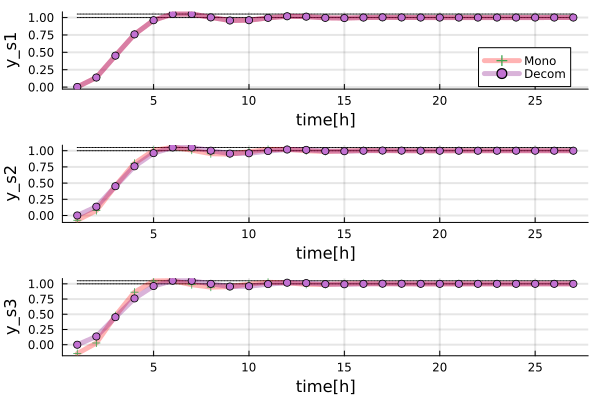

In [25]:
gr()
###########
# OUTPUTS #
###########
# limits
p9 = plot(ts,(pUB + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="y_s1",gridlinewidth=2)
p9 = plot!(ts,(pTrack + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black)

for opti in 1:2
    p9 = plot!(ts,yTraj[opti,:,1],linewidth=5,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti])
end
p9.series_list[1][:label] = ""
p9.series_list[2][:label] = ""
p9.series_list[3][:label] = "Mono"
p9.series_list[4][:label] = "Decom"

p10 = plot(ts,(pUB + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="y_s2",legend=false,gridlinewidth=2)
p10 = plot!(ts,(pTrack + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,legend=false)

for opti in 1:2
    p10 = plot!(ts,yTraj[opti,:,2],linewidth=5,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

p11 = plot(ts,(pUB + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="y_s3",legend=false,gridlinewidth=2)
p11 = plot!(ts,(pTrack + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black,legend=false)

for opti in 1:2
    p11 = plot!(ts,yTraj[opti,:,3],linewidth=5,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

g1 = plot(p9,p10,p11,layout=(3,1))
display(g1)

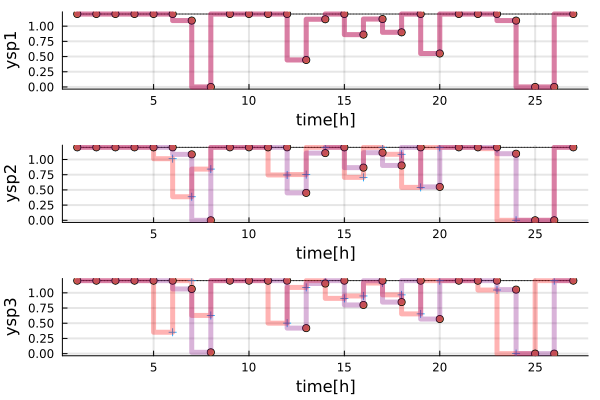

In [26]:
#############
# SETPOINTS #
#############
# limits
p12 = plot(ts,yspMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="ysp1",legend=false,gridlinewidth=2)
for opti in 1:2
    p12 = plot!(ts,yspTraj[opti,:,1],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

p13 = plot(ts,yspMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="ysp2",legend=false,gridlinewidth=2)
for opti in 1:2
    p13 = plot!(ts,yspTraj[opti,:,2],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

p14 = plot(ts,yspMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="ysp3",legend=false,gridlinewidth=2)
for opti in 1:2
    p14 = plot!(ts,yspTraj[opti,:,3],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

g2 = plot(p12,p13,p14,layout=(3,1))
display(g2)

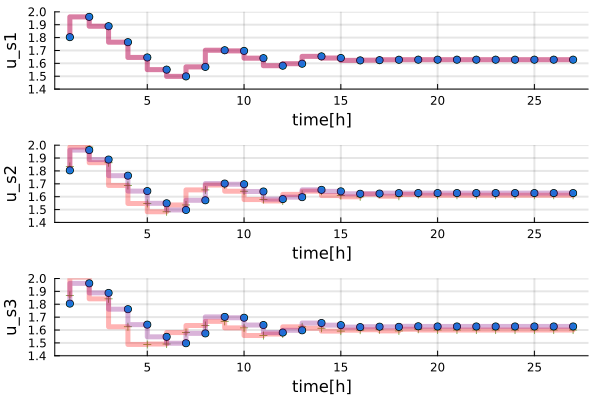

In [27]:
##########
# INPUTS #
##########
# limits
#p13 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="u1",legend=false,gridlinewidth=2,ylims = (1.5,2.0),yticks = 1.5:0.1:2.0)
p15 = plot(xaxis="time[h]",yaxis="u_s1",gridlinewidth=2,ylims = (1.4,2.0),yticks = 1.4:0.1:2.0)
for opti in 1:2
    p15 = plot!(ts,uTraj[opti,:,1],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

#p14 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="u2",legend=false,gridlinewidth=2,ylims = (1.5,2.0),yticks = 1.5:0.1:2.0)
p16 = plot(xaxis="time[h]",yaxis="u_s2",gridlinewidth=2,ylims = (1.4,2.0),yticks = 1.4:0.1:2.0)
for opti in 1:2
    p16 = plot!(ts,uTraj[opti,:,2],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

#p15 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="u3",legend=false,gridlinewidth=2,ylims = (1.5,2.0),yticks = 1.5:0.1:2.0)
p17 = plot(xaxis="time[h]",yaxis="u_s3",gridlinewidth=2,ylims = (1.4,2.0),yticks = 1.4:0.1:2.0)
for opti in 1:2
    p17 = plot!(ts,uTraj[opti,:,3],linewidth=5,linetype=:steppre,linealpha = 0.3,markershape=MList[opti],linecolor = CList[opti],legend=false)
end

g3 = plot(p15,p16,p17,layout=(3,1))
display(g3)

Creating table to show the results

In [28]:
# Scenarios
table_iter = Any[]
table_solTime_M = Any[]
table_solTime_D = Any[]
table_solMax = Any[]
table_of_M = Any[]
table_of_D = Any[]
table_perChange = Any[]

for tt in [5 10 15 20 25 30] 
    push!(table_iter, tt)
    push!(table_solTime_M, solTimeTraj_s[1,tt])
    push!(table_solTime_D, solTimeTraj_s[2,tt])
    push!(table_solMax, solTimeMaxTraj_s[tt])
    push!(table_of_M, solObjTraj_s[1,tt])
    push!(table_of_D, solObjTraj_s[2,tt])
    push!(table_perChange, (solObjTraj_s[2,tt] - solObjTraj_s[1,tt])/solObjTraj_s[1,tt])
end

df_scen = DataFrame(; iter = table_iter, 
                sol_time_M = table_solTime_M, 
                 sol_time_D = table_solTime_D,
                 sol_time_D_max = table_solMax,
                 comp_of_M = table_of_M,
                 comp_of_D = table_of_D,
                 per_change = table_perChange)

table_iter = Any[]
table_solTime_M = Any[]
table_solTime_D = Any[]
table_of_M = Any[]
table_of_D = Any[]
table_perChange = Any[]

for tt in [5 10 15 20 25 30] 
    push!(table_iter, tt)
    push!(table_solTime_M, solTimeTraj_r[1,tt])
    push!(table_solTime_D, solTimeTraj_r[2,tt])
    push!(table_of_M, solObjTraj_r[1,tt])
    push!(table_of_D, solObjTraj_r[2,tt])
    push!(table_perChange, (solObjTraj_r[2,tt] - solObjTraj_r[1,tt])/solObjTraj_r[1,tt])
end

df_reac = DataFrame(; iter = table_iter, 
                sol_time_M = table_solTime_M, 
                 sol_time_D = table_solTime_D,
                 comp_of_M = table_of_M,
                 comp_of_D = table_of_D,
                 per_change = table_perChange);

In [29]:
display("Analysis: # of Scenarios")
display(df_scen)

display("Analysis: # of Reactors")
display(df_reac)

"Analysis: # of Scenarios"

Row,iter,sol_time_M,sol_time_D,sol_time_D_max,comp_of_M,comp_of_D,per_change
,Any,Any,Any,Any,Any,Any,Any
1,5,0.0150001,0.198,0.0450003,0.432002,0.421942,-0.0232878
2,10,0.027,0.409,0.0450001,0.432023,0.422418,-0.0222332
3,15,0.0380001,0.631001,0.0490003,0.431915,0.422897,-0.0208787
4,20,0.043,0.690001,0.0390007,0.431907,0.423377,-0.0197502
5,25,0.053,0.948,0.046,0.431911,0.423864,-0.0186306
6,30,0.0580001,1.065,0.0900002,0.431899,0.424363,-0.0174482


"Analysis: # of Reactors"

Row,iter,sol_time_M,sol_time_D,comp_of_M,comp_of_D,per_change
,Any,Any,Any,Any,Any,Any
1,5,0.0239999,0.106,2.33974,2.1124,-0.097166
2,10,0.0280001,0.262,5.92345,5.25395,-0.113025
3,15,0.023,0.291,11.0021,9.67263,-0.12084
4,20,0.0470002,0.45,17.6261,15.5895,-0.115544
5,25,0.0480001,0.494999,26.0291,23.0003,-0.116362
6,30,0.062,0.665,36.2346,31.9566,-0.118064
